# `fmri-3`: Group analysis
This lab covers several approaches to simple second-level (i.e. group-level) statistical analysis in Python. We'll cover the parametric one-sample t-test, the two-sample t-test with independent samples, the paired t-test, a nonparametric permutation-based paired test, and a regression framework for more complex group-level modeling. In all cases, we'll run the group-level statistical test independently for each voxel (referred to as a massively univariate analysis). Finally, we'll consider the problem of multiple tests that arises in this massively univariate approach and control the false discovery rate (FDR) at .05. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Left/right button-press localizer dataset 
To demo the various group-level tests, we'll use example data from the Brainomics/Localizer database containing many functional localizer scans across 94 subjects ([Pinel et al., 2007](https://doi.org/10.1186/1471-2202-8-91); [Papadopoulos Orfanos et al., 2017](https://doi.org/10.1016/j.neuroimage.2015.09.052)). First, we'll load in the "left vs right button press" contrast maps (and first-level t-value maps) for a subset of 16 subjects. (If you're working on the PNI server, you can use the existing data downloaded at `data_dir`; however, if you're working locally, you'll need to change `data_dir` to a directory on your machine and download the data.

In [3]:
# Download left vs. right contrast maps for 16 subjects
from nilearn.datasets import fetch_localizer_contrasts

data_dir = '/usr/people/bs1799/neu502b/nilearn_data'
# data_dir = '/Users/snastase/Work/neu502b-2023/nilearn-data'

n_subjects = 16
localizer_dataset = fetch_localizer_contrasts(['left vs right button press'],
                                              n_subjects, get_tmaps=True,
                                              data_dir=data_dir)

[fetch_localizer_contrasts] Dataset found in 
/usr/people/bs1799/neu502b/nilearn_data/brainomics_localizer

First, we'll plot the t-value maps for the left vs. right button-press contrast for each of the 16 subjects. The first-level t-value is mean contrast normalized by the variance over time within a given subject. Note that the t-maps are relatively noisy across individual subjects.

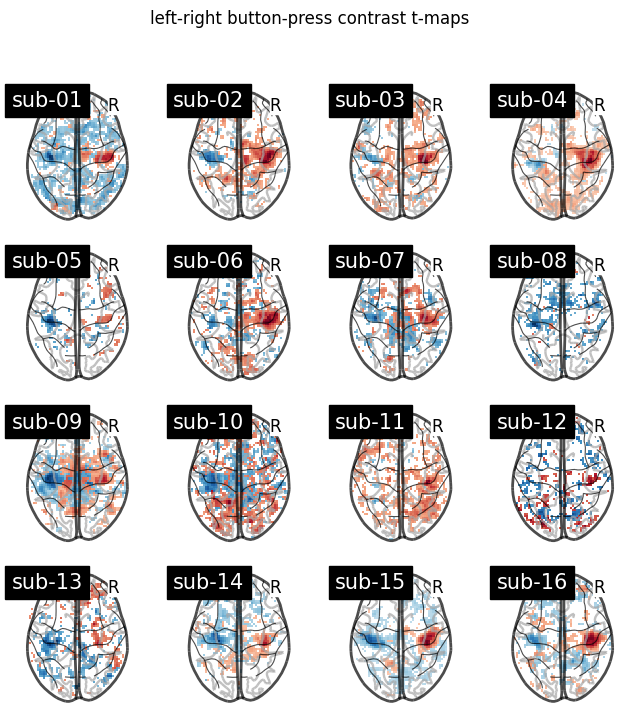

In [4]:
# Plot t-maps for all 16 example subjects
from nilearn.plotting import plot_glass_brain

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for s, tmap in enumerate(localizer_dataset['tmaps']):
    plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                     title=f'sub-{s+1:02}',
                     axes=axes[int(s / 4), int(s % 4)],
                     plot_abs=False, display_mode='z');
fig.suptitle('left-right button-press contrast t-maps');

### Parametric one-sample t-test
To perform second-level statistical test for population inference, we'll use a one-sample t-test. Here, the t-test is testing the null hypothesis that the mean contrast value is zero. The degrees of freedom are the sample size *N* – 1 (i.e. in this example where `n_subjects` = 16, 16 – 1 = 15 degrees of freedom). The t-test is a parametric test in that it relies on the t-distribution and the corresponding assumptions (e.g. normality). For a given sample size, a t-value has a corresponding p-value. *A p-value of .05 means that there is 5% probability (under a specified statistical model) of obtaining the observed (statistical summary of the) data if the null hypothesis were true.* We'll begin by loading in the contrast maps using a whole-brain mask based on the MNI template. 

In [5]:
# Apply anatomically-defined MNI mask to data
from nilearn.maskers import NiftiMasker

masker = NiftiMasker(mask_strategy='whole-brain-template')
group_data = masker.fit_transform(localizer_dataset['cmaps'])

Perform the one-sample t-test using scipy's [ttest_1samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html). This will yield both t- and p-values. Reshape these results back into the original NIfTI image using `masker.inverse_transform`. Visualize the resulting t-values with `plot_glass_brain`, thresholded by an (uncorrected) t-value of `3.3` (corresponding to p < .005 with DF = 15).

In [8]:
# Run simple parametric t-test via scipy:
from scipy.stats import ttest_1samp

t_values, p_values = ttest_1samp(group_data, popmean = 0)


# Reshape masked result into 3D NIfTI image:
t_map = masker.inverse_transform(t_values)
p_map = masker.inverse_transform(p_values)

/tmp/ipykernel_3194821/1904994120.py:5: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  plot_glass_brain(t_map, colorbar = True, threshold = threshold,


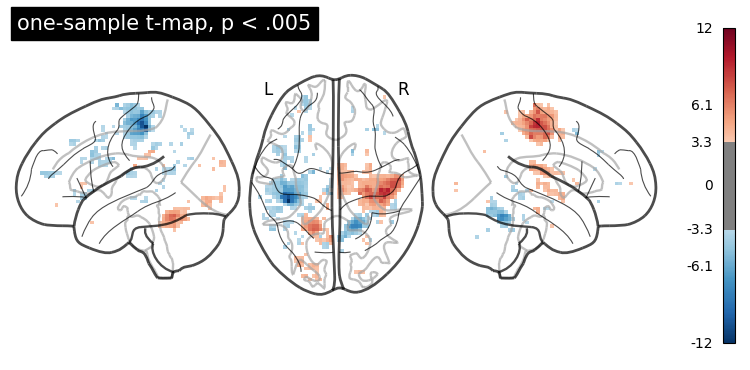

In [15]:
# T-value for p < .005 with DF = 15
threshold = 3.3

# Plot glass brain visualization of t-values:
plot_glass_brain(t_map, colorbar = True, threshold = threshold, 
                title = 'one-sample t-map, p < .005', 
                plot_abs = False, display_mode = 'lzr')

### Parametric two-sample unpaired t-test
Next, we'll perform a two-sample t-test with independent (i.e. unpaired) samples. This design corresponds to a between-subject manipulation where one group of subjects is randomly assigned to one condition (e.g. left button-press) and the other group is assigned to the other condition (e.g. right button-press). The two-sample t-test tests the null hypothesis that the difference between the means of the two groups is zero. In this example dataset, each subject actually received both conditions—but to simulate the two-sample unpaired test, we'll download the left button-press condition for one subset of 16 subjects, and the right button-press condition for a non-overlapping subset of 16 subjects. We'll run the independent samples t-test using scipy's [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind) and visualize the resulting t-values.

In [10]:
# Download non-overlapping samples of subjects for each condition
n_subjects = 16

sample1 = np.arange(1, n_subjects + 1)
sample2 = np.arange(n_subjects + 1, n_subjects + n_subjects + 1)

localizer_dataset1 = fetch_localizer_contrasts(['left button press'],
                                               sample1, get_tmaps=True,
                                               data_dir=data_dir)
localizer_dataset2 = fetch_localizer_contrasts(['right button press'],
                                               sample2, get_tmaps=True,
                                               data_dir=data_dir)

[fetch_localizer_contrasts] Dataset found in 
/usr/people/bs1799/neu502b/nilearn_data/brainomics_localizer

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27c81645253a001c3e1f85/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27c0a6a26b340017082996/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27d62e114a420017049501/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27d5e4114a4200170494d7/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27e99245253a001c3e3c24/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27e113114a420017049aeb/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27f9ec114a42001605ac1f/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27f49045253a00193cb4da/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d280363a26b340019089b97/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2806a9114a42001605b7d0/ ...

[fetch_localizer_contrasts]  ...done. (3 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28193d114a42001804761c/ ...

[fetch_localizer_contrasts]  ...done. (3 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d281983a26b34001609cb01/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d281b9945253a001b3c4688/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d281d9945253a00193cce2c/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d282ff145253a001c3e86db/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2835e145253a00193ce9ca/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2845cb114a42001605f6ca/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2844f6a26b3400170876e7/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d284f19114a420016060043/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28585b45253a001c3eafbf/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2863d3114a420016061028/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d285f6b1c5b4a001aa11dd6/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d286ca11c5b4a001b9f6276/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d286bcf114a42001804ab56/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2880af114a42001804b682/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28829945253a001b3c8938/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28926ba26b34001808c17c/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d289038a26b34001908ff16/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28a134114a42001904cfae/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28a81aa26b3400160a59a6/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28baf61c5b4a001aa19406/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28b234a26b340019091e61/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Dataset found in 
/usr/people/bs1799/neu502b/nilearn_data/brainomics_localizer

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28ceed45253a001c3f31d1/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28c62d1c5b4a001c9f3a11/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28d9a51c5b4a001aa1b263/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28db0a1c5b4a001da044ab/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28ed0e45253a001a3ce964/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28eb15a26b3400160a9780/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28f5b045253a001c3f52a0/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2900de45253a00193d7e2b/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2904bc45253a001a3cf549/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2907621c5b4a001aa1dfaa/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2921bfa26b340019095d81/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2917b945253a001c3f6d5f/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d292a1745253a001b3cf074/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d292a81a26b3400160ac408/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d293e8f1c5b4a001c9f71c7/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d293e461c5b4a001da07b4a/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2949ba1c5b4a001aa21686/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d294ae31c5b4a001aa217b4/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2950eb45253a001b3d00e8/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d294f8645253a00193da543/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c3306a26b3400160d37ef/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c3ada45253a001c42101f/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c4dda1c5b4a001ba1ba8e/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c43dd1c5b4a001da245a5/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c5fb11c5b4a001da25b26/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c574ba26b3400160d56b0/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c748345253a001b3e7a7d/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2c7764a26b3400160d79a7/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2ec864251f0e0018041c62/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2ebeb6251f0e0017043991/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2ed5145d2cdc001702b7fa/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2ed33f251f0e001604bdc3/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

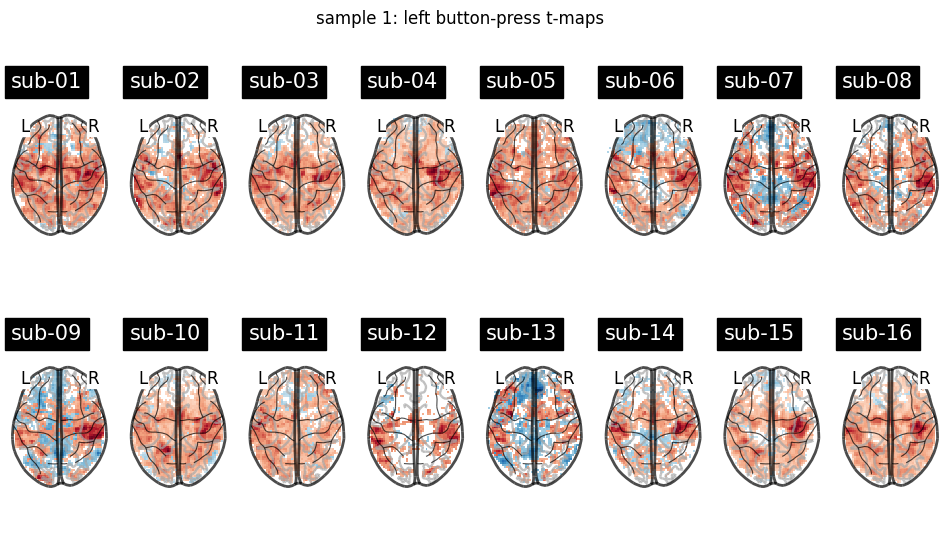

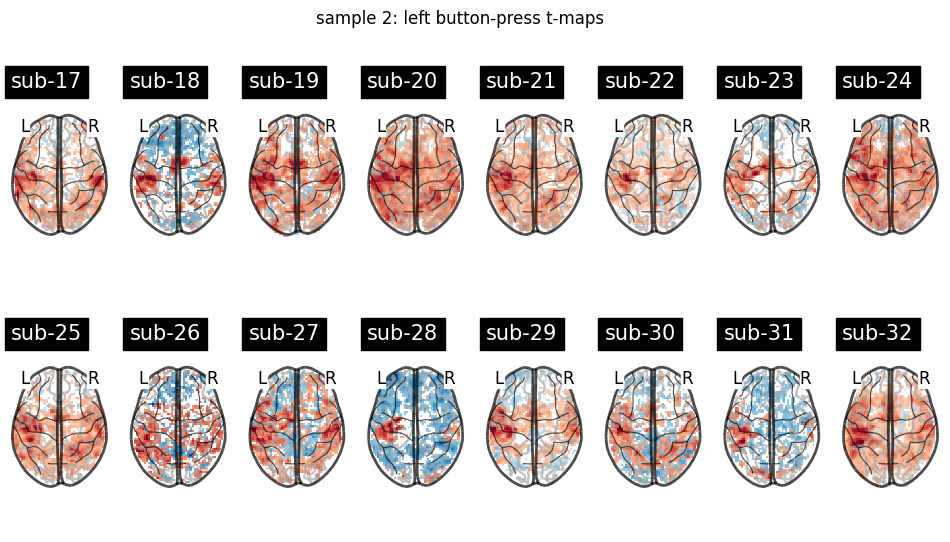

In [11]:
# Plot t-maps for 16 left button-press subjects
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(12, 6))
for i, (s, tmap) in enumerate(zip(sample1, localizer_dataset1['tmaps'])):
    plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                     title=f'sub-{s:02}',
                     axes=axes[int(i / 8), int(i % 8)],
                     plot_abs=False, display_mode='z');
fig.suptitle('sample 1: left button-press t-maps');

# Plot t-maps for 16 right button-press subjects
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(12, 6))
for i, (s, tmap) in enumerate(zip(sample2, localizer_dataset2['tmaps'])):
    plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                     title=f'sub-{s:02}',
                     axes=axes[int(i / 8), int(i % 8)],
                     plot_abs=False, display_mode='z');
fig.suptitle('sample 2: left button-press t-maps');

In [12]:
# Load in data from two groups and apply mask
group_data1 = masker.fit_transform(localizer_dataset1['cmaps'])
group_data2 = masker.fit_transform(localizer_dataset2['cmaps'])

Run the independent-samples t-test using scipy's [ttest_ind](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html). Reshape the results back into the original NIfTI image and  visualize the resulting t-values thresholded by an (uncorrected) t-value of `3.6` (corresponding to p < .005 with DF = 16 + 16 – 2 = 30).

In [10]:
# Run simple parametric t-test via scipy:
from scipy.stats import ttest_ind

t_values, p_values = ttest_ind(group_data1, group_data2)


# Reshape masked result into 3D NIfTI image:
t_map = masker.inverse_transform(t_values)
p_map = masker.inverse_transform(p_values)

/tmp/ipykernel_3194821/3006750295.py:5: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  plot_glass_brain(t_map, colorbar = True, threshold = threshold,


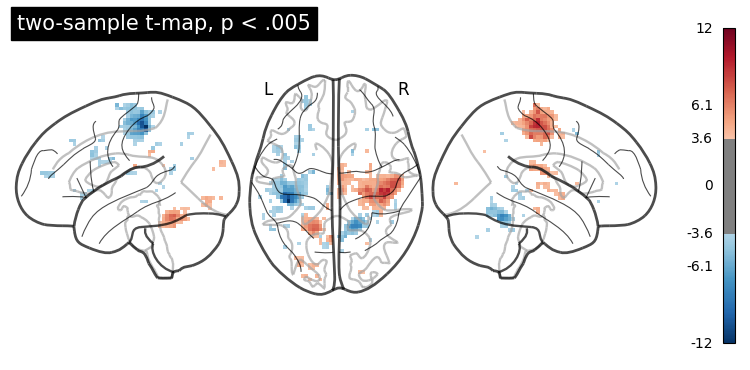

In [17]:
# T-value for p < .005 with DF 16 + 16 - 2 = 30
threshold = 3.6

# Plot glass brain visualization of t-values:
plot_glass_brain(t_map, colorbar = True, threshold = threshold, 
                title = 'two-sample t-map, p < .005', 
                plot_abs = False, display_mode = 'lzr');

### Parametric two-sample paired t-test
Given the experimental design of the example dataset—where each subject received both conditions of interest–we should perform a paired t-test. This tests the null hypothesis that the within-subjects difference between the left vs. right button-press is zero. We'll use scipy's [ttest_rel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel) to run the paired t-test, then visualize the results. (Spoiler: this is effectively the same analysis as running a one-sample t-test on the within-subject left vs. right button-press contrast maps.)

In [14]:
# Download both conditions for 16 subjects
n_subjects = 16

localizer_dataset1 = fetch_localizer_contrasts(['left button press'],
                                               n_subjects, get_tmaps=True,
                                               data_dir=data_dir)
localizer_dataset2 = fetch_localizer_contrasts(['right button press'],
                                               n_subjects, get_tmaps=True,
                                               data_dir=data_dir)

[fetch_localizer_contrasts] Dataset found in 
/usr/people/bs1799/neu502b/nilearn_data/brainomics_localizer

[fetch_localizer_contrasts] Dataset found in 
/usr/people/bs1799/neu502b/nilearn_data/brainomics_localizer

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27cae21c5b4a001aa07de2/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27ca1645253a001a3c29b0/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27d455a26b340019087fa6/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27cf67a26b340019087cb9/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27df2745253a001c3e32ad/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27e94c45253a001b3c2994/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27f08845253a00193cb237/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27edcea26b3400170840d3/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d280594114a420018046b3c/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d27fc81114a4200190465f1/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28164d114a42001704bc13/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2815fea26b34001609c852/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d281f62114a42001704c0dc/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d282019a26b34001908ac92/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d282cfb45253a001c3e7fdc/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2838be45253a001c3e91dc/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d283f76114a4200190492ed/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d284ac61c5b4a001aa10d23/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d285959a26b3400160a0c4e/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28581445253a001c3eaf88/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d285bd31c5b4a001d9fcd2a/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2868b7114a42001804a96e/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d286c50a26b34001908e423/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2877f0a26b3400170890a0/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d288179114a4200170505a3/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d2881a545253a001b3c888a/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d289615a26b34001808c438/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d288e7b114a4200160637b5/ ...

[fetch_localizer_contrasts]  ...done. (2 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28afa1114a420017052e4a/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28b090a26b340019091c63/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28c171a26b34001708c835/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

[fetch_localizer_contrasts] Downloading data from 
https://osf.io/download/5d28b98ba26b3400160a6de9/ ...

[fetch_localizer_contrasts]  ...done. (1 seconds, 0 min)

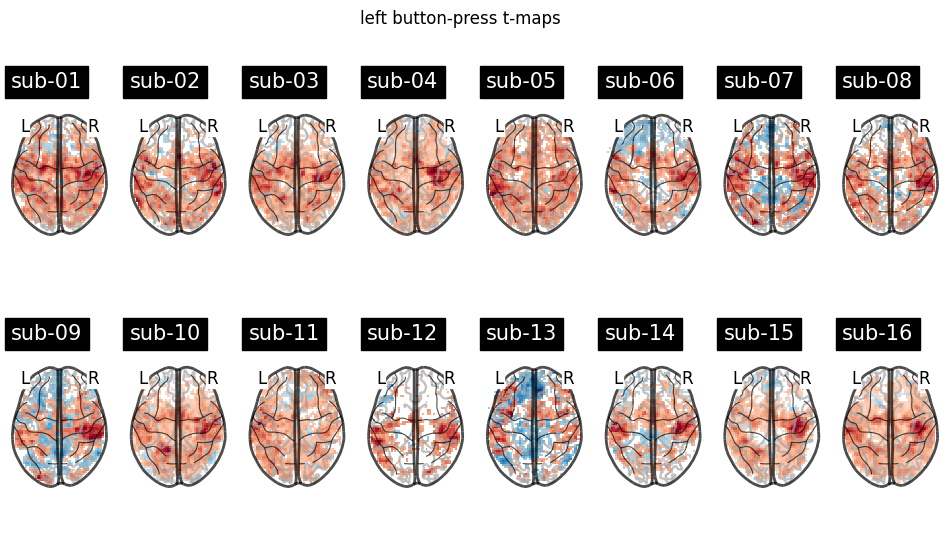

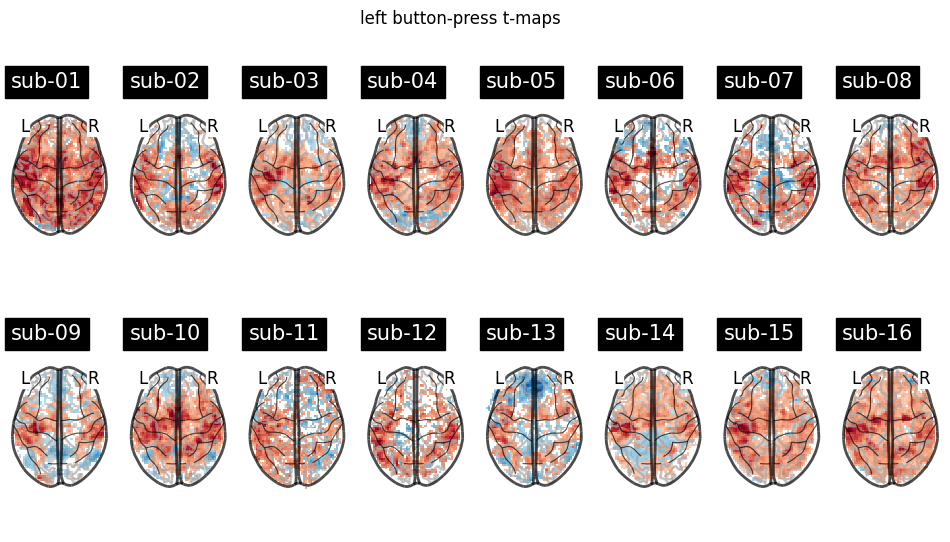

In [18]:
# Plot t-maps for both conditions across 16 subjects
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(12, 6))
for s, tmap in enumerate(localizer_dataset1['tmaps']):
    plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                     title=f'sub-{s+1:02}',
                     axes=axes[int(s / 8), int(s % 8)],
                     plot_abs=False, display_mode='z');
fig.suptitle('left button-press t-maps');

fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(12, 6))
for s, tmap in enumerate(localizer_dataset2['tmaps']):
    plot_glass_brain(tmap, colorbar=False, threshold=2.0,
                     title=f'sub-{s+1:02}',
                     axes=axes[int(s / 8), int(s % 8)],
                     plot_abs=False, display_mode='z');
fig.suptitle('left button-press t-maps');

In [19]:
# Load in data from two groups and apply mask
pair_data1 = masker.fit_transform(localizer_dataset1['cmaps'])
pair_data2 = masker.fit_transform(localizer_dataset2['cmaps'])

Run the paired t-test using scipy's [ttest_rel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html). Reshape the results back into the original NIfTI image and  visualize the resulting t-values thresholded by an (uncorrected) t-value of `3.3` (corresponding to p < .005 with DF = 15).

In [20]:
# Run simple parametric t-test via scipy:
from scipy.stats import ttest_rel

t_values, p_values = ttest_rel(pair_data1, pair_data2)

# Reshape masked result into 3D NIfTI image:
t_map = masker.inverse_transform(t_values)
p_map = masker.inverse_transform(p_values)

/tmp/ipykernel_3194821/2097198933.py:5: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  plot_glass_brain(t_map, colorbar = True, threshold = threshold,


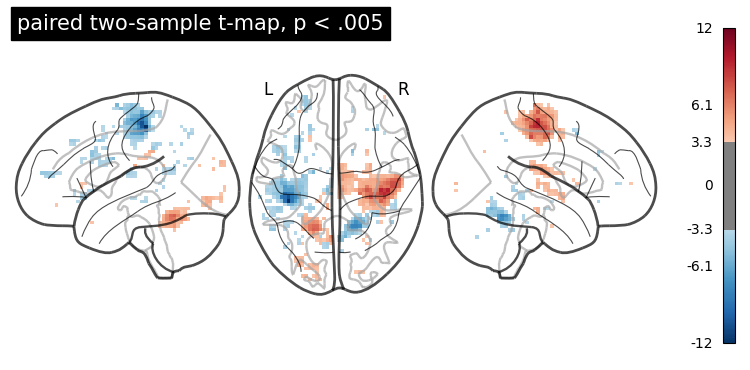

In [21]:
# T-value for p < .005 with DF = 15
threshold = 3.3

# Plot glass brain visualization of t-values:
plot_glass_brain(t_map, colorbar = True, threshold = threshold, 
                title = 'paired two-sample t-map, p < .005', 
                plot_abs = False, display_mode = 'lzr');

### Nonparametric permutation-based paired test
In some cases where our data may violate certain distributional assumptions (e.g. normality) of the parametric t-test, we can perform a permutation test. Here, we devise a general permutation scheme for paired difference. The goal of the permutation-based approach is to construct a null distribution by randomly shuffling the within-subject condition assignments—or, equivalently, flipping the sign of within-subject differences between the two conditions (i.e. multiplying by +1 or -1). For a sample size of 16 differences, there are $2^{16} = 65536$  possible permutations. Performing an exact test with all possible permutations would be computationally costly, so we'll randomly choose a subset of all possible permutations to construct the null distribution.

In [22]:
# Compute the actual observed paired differences and mean difference
paired_difference = pair_data1 - pair_data2
mean_difference = np.mean(paired_difference, axis=0)

# For a small sample (e.g. N = 16), we can generate
# all possible permutations 2 ** 16 = 65,536
max_permutations = 2 ** n_subjects

from itertools import product
all_permutations = np.array(list(product([-1, 1], repeat=n_subjects)))
assert len(all_permutations) == max_permutations

# Randomly choose a subset of all possible permutations without replacement 
n_permutations = 5000
permutation_ids = np.random.choice(np.arange(len(all_permutations)),
                                   size=n_permutations, replace=False)
permutations = all_permutations[permutation_ids]

# Loop through permutations to populate null distribution
null_distribution = []
for i, permutation in enumerate(permutations):
    
    # Apply the permutation to randomly flip the sign of the differences
    permuted_difference = permutation[:, np.newaxis] * paired_difference
    
    # Compute the mean of the permuted differences
    permuted_mean = np.mean(permuted_difference, axis=0)
    null_distribution.append(permuted_mean)
    
    if i > 0 and i % 500 == 0:
        print(f"Finished {i} permutations")

null_distribution = np.array(null_distribution)

Finished 500 permutations
Finished 1000 permutations
Finished 1500 permutations
Finished 2000 permutations
Finished 2500 permutations
Finished 3000 permutations
Finished 3500 permutations
Finished 4000 permutations
Finished 4500 permutations


After constructing the null distribution from resampling our actual data with randomized condition assignments (for each voxel), we'll compute p- and z-values capturing how far our observed mean differences fall along the tail of the null distribution. We'll then visualizing the brain map of permutation-based z-values, as well as the null distribution for an example voxel.

In [23]:
# Compute p-value and z-value from null distribution
group_p = ((np.sum(np.abs(null_distribution) >= np.abs(mean_difference), axis=0) + 1) /
           (n_permutations + 1))
group_p[np.isnan(mean_difference)] = np.nan

group_z = ((mean_difference - np.nanmean(null_distribution, axis=0)) /
           np.nanstd(null_distribution, axis=0))

# Reshape flattened result into 3D NIfTI image
z_map = masker.inverse_transform(group_z)
p_map = masker.inverse_transform(group_p)

/tmp/ipykernel_3194821/3909149800.py:6: RuntimeWarning: invalid value encountered in divide
  group_z = ((mean_difference - np.nanmean(null_distribution, axis=0)) /


/tmp/ipykernel_3194821/3728941730.py:4: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  plot_glass_brain(z_map, threshold=threshold, colorbar=True,


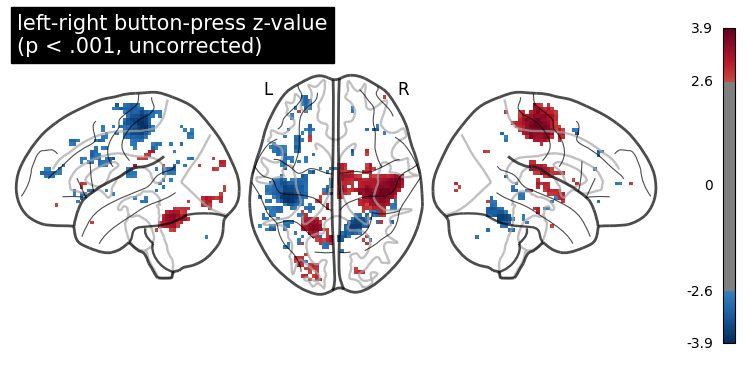

In [24]:
# Z-value for permutation-based p < .005
threshold = 2.6

plot_glass_brain(z_map, threshold=threshold, colorbar=True,
                 display_mode='lzr', plot_abs=False,
                 title=('left-right button-press z-value\n'
                        '(p < .001, uncorrected)'));

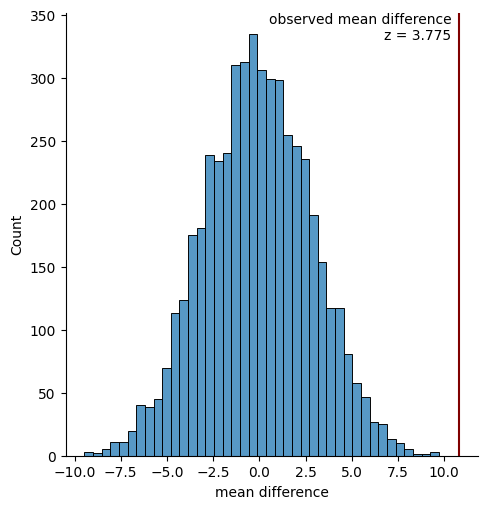

In [25]:
# Plot null distribution and observed value for a good voxel
example_voxel = 5977
sns.displot(null_distribution[:, example_voxel])
plt.xlabel('mean difference')
plt.axvline(mean_difference[example_voxel], c='maroon')
plt.annotate('observed mean difference\n'
             f'z = {group_z[example_voxel]:.3f}',
             xy=(.935, .94), ha='right', xycoords='axes fraction');

### Parametric group-level regression model
Simple group-level statistical analyses such as the t-test can be reframed in a more flexible regression model. Here, we return to the scenario of a between-subjects design with two independent samples. Similarly to the first-level analysis, we'll construct a design matrix capturing the between-subject left vs. right button-press manipulation. However, in the context of multiple regression, we can also include covariates or confounds. In this example, we'll construct a regression model that includes the between-subject left vs. right button-press manipulation, as well as covariates for age and reported sex. We'll visualize the resulting design matrix, fit the model, then compute z-values for the contrast of interest.

In [29]:
# Load two independent samples of subjects for left/right button-press task
n_subjects = 16

sample1 = np.arange(1, n_subjects + 1)
sample2 = np.arange(n_subjects + 1, n_subjects + n_subjects + 1)

localizer_dataset1 = fetch_localizer_contrasts(['left button press'],
                                               sample1, get_tmaps=True,
                                               data_dir=data_dir)
localizer_dataset2 = fetch_localizer_contrasts(['right button press'],
                                               sample2, get_tmaps=True,
                                               data_dir=data_dir)

[fetch_localizer_contrasts] Dataset found in 
/usr/people/bs1799/neu502b/nilearn_data/brainomics_localizer

[fetch_localizer_contrasts] Dataset found in 
/usr/people/bs1799/neu502b/nilearn_data/brainomics_localizer

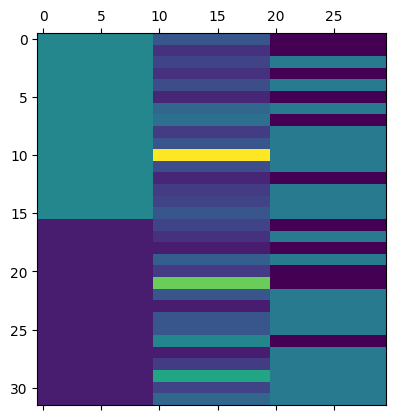

In [38]:
import pandas as pd
from scipy.stats import zscore

# Combine contrast filenames into single list of filenames
second_level_input = localizer_dataset1['cmaps'] + localizer_dataset2['cmaps']

# print(localizer_dataset1)
# print(localizer_dataset1['ext_vars']['age'])

# Condition regressor where left is 1 and right is -1
condition = np.hstack(([1] * n_subjects, [-1] * n_subjects))

# We can include age as a continuous covariate
age = ([int(s) for s in localizer_dataset1['ext_vars']['age']] + 
       [int(s) for s in localizer_dataset2['ext_vars']['age']])
# # old way, throws an error
# age = ([int(s[1]) for s in localizer_dataset1['ext_vars']] + 
#        [int(s[1]) for s in localizer_dataset2['ext_vars']])


# We can also include reported sex as a covariate
sex = ([s for s in localizer_dataset1['ext_vars']['sex']] +
       [s for s in localizer_dataset2['ext_vars']['sex']])
# # old way, throws an error
# sex = ([s[2] for s in localizer_dataset1['ext_vars']] +
#        [s[2] for s in localizer_dataset2['ext_vars']])
sex = [1 if s == 'F' else -1 for s in sex]

# Assemble the group-level design matrix
design_matrix = pd.DataFrame(np.column_stack((condition, age, sex)),
                             columns=['left vs. right button',
                                      'age', 'sex'])

# Visualize design matrix
plt.matshow(np.repeat(zscore(design_matrix.values), 10, axis=1));

In [39]:
# Fit second-level model (with mask)
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(mask_img=masker).fit(
    second_level_input, design_matrix=design_matrix)

# Compute z-statistic for left vs. right contrast
z_map = second_level_model.compute_contrast('left vs. right button',
                                            output_type='z_score')

/tmp/ipykernel_3194821/3476871230.py:4: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_img :
    Masker parameter None - overriding estimator parameter NiftiMasker(mask_strategy='whole-brain-template')

  second_level_model = SecondLevelModel(mask_img=masker).fit(
/tmp/ipykernel_3194821/3476871230.py:4: UserWarning: [NiftiMasker.fit] Generation of a mask has been requested (imgs != None) while a mask was given at masker creation. Given mask will be used.
  second_level_model = SecondLevelModel(mask_img=masker).fit(
/usr/people/bs1799/miniconda3/envs/neu502b/lib/python3.12/site-packages/nilearn/glm/_utils.py:207: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


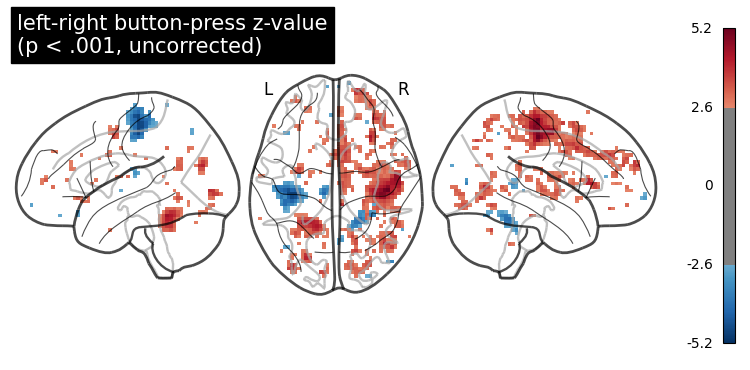

In [40]:
# Z-value for regression coefficient p < .005
threshold = 2.6

plot_glass_brain(z_map, threshold=threshold, colorbar=True,
                 display_mode='lzr', plot_abs=False,
                 title=('left-right button-press z-value\n'
                        '(p < .001, uncorrected)'));

### Correction for multiple tests
Performing tens of thousands of statistical tests across voxels introduces the problem of multiple tests. That is, by running many tests, we should expect a considerable number to appear "significant" just by chance alone. There are many ways to correct for multiple tests, such as nonparametric approaches that take into account the clustered spatial structure of significant voxels in a brain image. Here, we'll use a simple approach that controls the false discovery rate (FDR)—i.e. probability of observing false positives across all tests—at .05 ([Benjamini & Hochberg, 1995](https://doi.org/10.1111/j.2517-6161.1995.tb02031.x)). We'll use the [`multipletests`](https://www.statsmodels.org/stable/generated/statsmodels.stats.multitest.multipletests.html) tool from `statsmodels` to implement FDR control.

In [41]:
# Control false discovery rate (FDR) at .05
from statsmodels.stats.multitest import multipletests

sig, group_q = multipletests(group_p, alpha=.05, method='fdr_bh')[:2]

# Create FDR-thresholded z-map
group_sig = group_z.copy()
group_sig[~sig] = np.nan
sig_map = masker.inverse_transform(group_sig)

/tmp/ipykernel_3194821/2301990448.py:4: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  plot_glass_brain(sig_map, threshold=threshold, colorbar=True,


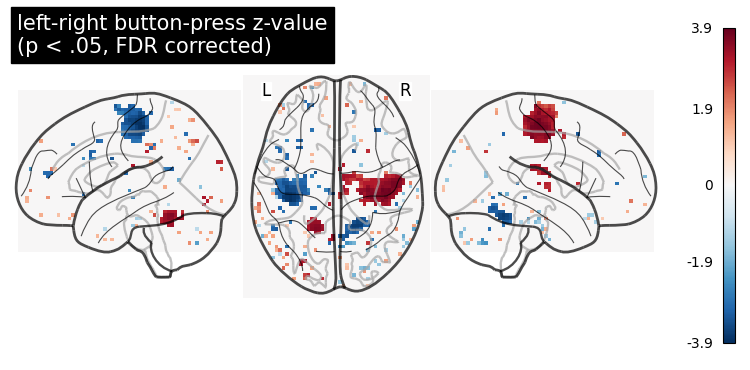

In [42]:
# Z-value for thresholded at FDR = .05
threshold = None

plot_glass_brain(sig_map, threshold=threshold, colorbar=True,
                 display_mode='lzr', plot_abs=False,
                 title=('left-right button-press z-value\n'
                        '(p < .05, FDR corrected)'));

#### References

* Benjamini, Y., & Hochberg, Y. (1995). Controlling the false discovery rate: a practical and powerful approach to multiple testing. *Journal of the Royal Statistical Society: Series B (Methodological)*, *57*(1), 289–300. https://doi.org/10.1111/j.2517-6161.1995.tb02031.x

* Papadopoulos Orfanos, D., Michel, V., Schwartz, Y., Pinel, P., Moreno, A., Le Bihan, D., & Frouin, V. (2017). The Brainomics/Localizer database. *NeuroImage*, *144*, 309–314. https://doi.org/10.1016/j.neuroimage.2015.09.052

* Pinel, P., Thirion, B., Meriaux, S., Jobert, A., Serres, J., Le Bihan, D., Poline, J.-B., & Dehaene, S. (2007). Fast reproducible identification and large-scale databasing of individual functional cognitive networks. *BMC Neuroscience*, *8*, 91. https://doi.org/10.1186/1471-2202-8-91